# Jacknife Example
#### by Elizabeth Barnes

Simple demonstration of a jackknife approach.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#.............................................
# IMPORT STATEMENTS
#.............................................
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy.stats as stats
import scipy.io as sio

import general_functions as gf
importlib.reload(gf)
gf.add_parent_dir_to_path()

from lib import class_general_functions as cgf
importlib.reload(cgf)

#.............................................
# PLOTTING COMMANDS
#.............................................
gf.cc()
plt.ioff()

We begin by loading the data. We are going to load the [North Atlantic Oscillation (NAO)](https://en.wikipedia.org/wiki/North_Atlantic_oscillation) timeseries and then grab January days only (the first column).

In [2]:
DATA = sio.loadmat('data/nao_timeseries.mat')
X = DATA['NAO'][:,0] # grab January data only
TIME_NAO = DATA['TIME_NAO'][:,0]

del DATA

Like all good data scientists, we first *plot our data* to get a feeling for what it looks like. We can also plot the best-fit line through all of the points.

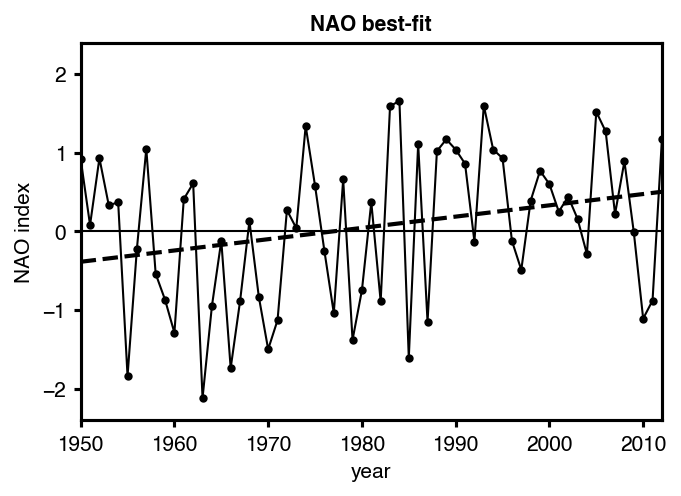

In [3]:
fig, ax = cgf.cfig(1)
plt.plot(TIME_NAO,X, '.-', color = 'black', linewidth = 1.0)
pfull = np.polyfit(TIME_NAO,X,1)
plt.plot(TIME_NAO,TIME_NAO*pfull[0]+pfull[1],'--',color = 'black')

plt.xlabel('year');
plt.ylabel('NAO index');
plt.ylim(-2.4,2.4);
plt.xlim(min(TIME_NAO), max(TIME_NAO));

plt.title('NAO best-fit');

gf.plot_zero_lines();

fig

The dashed line above shows the best fit line. What are the slope and y-intercept?

In [4]:
slope = pfull[0]
yint = pfull[1]

print('slope = ' + str(slope) + '; y-intercept = ' + str(yint))

slope = 0.0143548387097; y-intercept = -28.3789989759


But how "certain" are we of these values? That is, what might the error or uncertainty range be of the slope and y-intercept? One way to tackle this question is using a method called [**Jackknife Resampling**](https://en.wikipedia.org/wiki/Jackknife_resampling).

The idea is that we systematically remove each data point, re-calculate the slope and y-intercept without that data point, replace the data point we just removed, and then repeat for the next data point being remove. This is what the code below is doing...

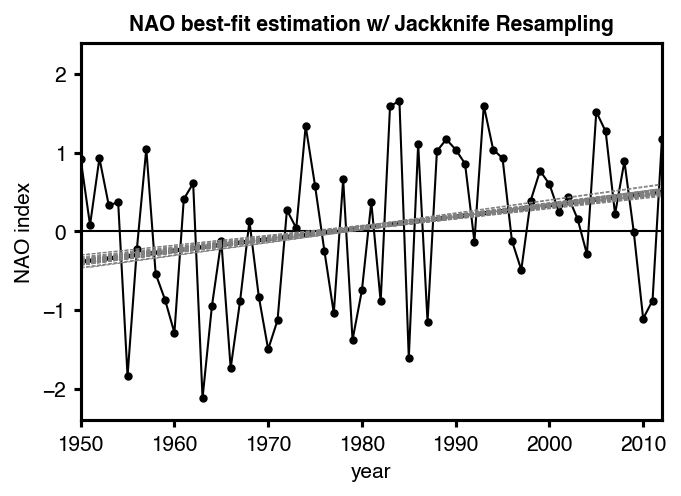

In [5]:
M = np.empty([len(X),2])

for j, val in enumerate(X):
    
    X2 = X
    X2 = np.delete(X2,j)
    
    T2 = TIME_NAO
    T2 = np.delete(T2,j)
    
    pfull = np.polyfit(T2,X2,1)
    
    M[j,0] = pfull[0]
    M[j,1] = pfull[1]
    
    ax.plot(T2,T2*pfull[0] + pfull[1],'--', color = 'gray', linewidth = .5)

    if(j==40): #example to be plotted in the following figure
        pfull_example = pfull
        val_example = val
        j_example = j
    
plt.title('NAO best-fit estimation w/ Jackknife Resampling')
fig

Each line drawn above is a different line for a different data point being remove. For example, removing the 40th point...

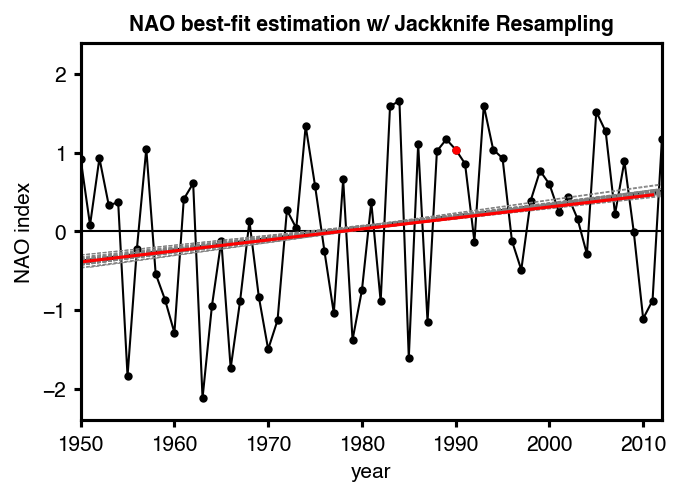

In [6]:
# plot an illustrative example
ax.plot(TIME_NAO[j_example],val_example,'.',color = 'red')
ax.plot(T2,T2*pfull_example[0] + pfull_example[1],'-', color = 'red', linewidth = 1.5)
fig

The plot above shows the 40th point (in red), and the best-fit line that one would calculate if this 40th point is removed from the series.

#### What now?
Ok - now that we've done all of these calculations, and computed the slope and y-intercept for when each point is systematically removed - now what? Well, the idea is that we now have a bunch of estimates for both the slope and the y-intercept. So, we can make a histogram of these values (one plot for the slope and one plot for the y-intercept). This is what is done below.

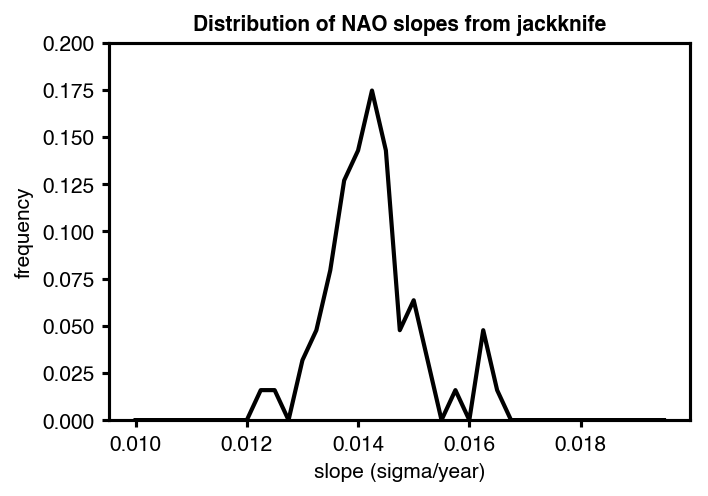

In [7]:
xint = np.arange(.01,.02,.00025)
y, bin_edges = np.histogram(M[:,0],xint)

fig1, ax1 = cgf.cfig(2)
plt.plot(bin_edges[:-1],y/float(len(M)))

plt.ylim(0,.2)
plt.xlabel('slope (sigma/year)')
plt.ylabel('frequency')
plt.title('Distribution of NAO slopes from jackknife')
fig1

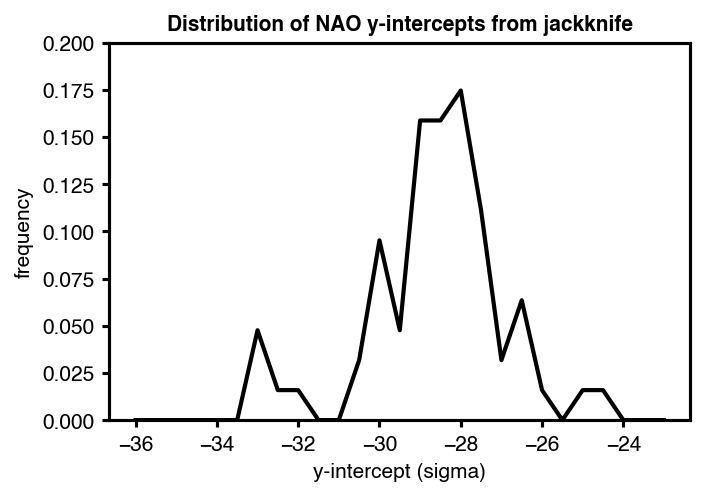

In [8]:
xint = np.arange(-36.,-22.,.5)
y, bin_edges = np.histogram(M[:,1],xint)

fig2, ax2 = cgf.cfig(3)
plt.plot(bin_edges[:-1],y/float(len(M)))

plt.ylim(0,.2)
plt.xlabel('y-intercept (sigma)')
plt.ylabel('frequency')
plt.title('Distribution of NAO y-intercepts from jackknife')
fig2

Given the distributions above, we can make statements about our _best guess_ of the slope and y-intercept of our fits. That is, our best guess slope is the mean of our individual estimates of the slope, and our _best guess_ of the y-intercept is the mean of our individual estimates of the y-intercept. A range of uncertainty in our estimates of the slope and the y-intercept can be quantified from the spread in the distribution. The figures below illustrate these ideas.

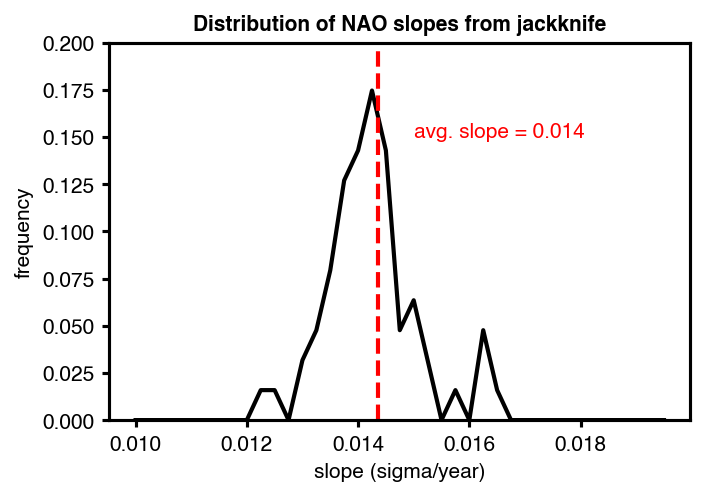

In [9]:
mean_slope = np.mean(M[:,0])
ax1.plot((mean_slope,mean_slope),(0,.2),'--r')
ax1.text(.015,.150,'avg. slope = ' + str(gf.round_to_nearest(mean_slope,.001)), color = 'red')
fig1

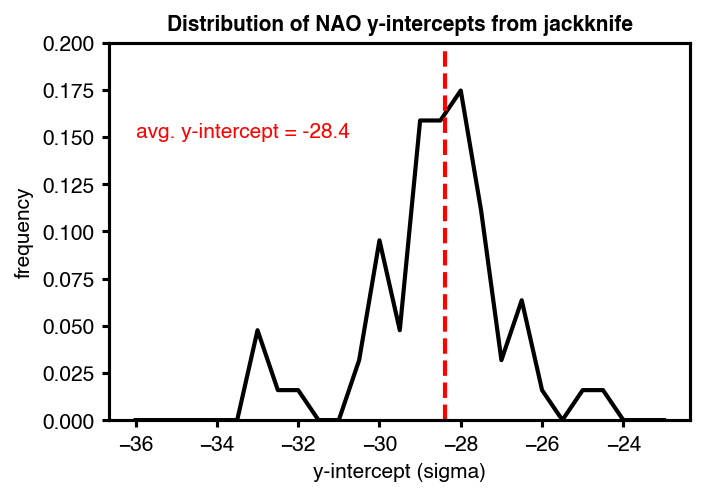

In [10]:
mean_yint = np.mean(M[:,1])
ax2.plot((mean_yint,mean_yint),(0,.2),'--r')
ax2.text(-36,.150,'avg. y-intercept = ' + str(gf.round_to_nearest(mean_yint,.1)), color = 'red')
fig2